In [2]:
import os
import sys
from google.colab import drive 
# Enlazar a la carpeta 'data'
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ICBF/data')
sys.path.insert(0, '../scripts/0_utils')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ICBF/data


# **Modelado a partir de las variables del beneficiario**

####**Descripción:**

Explora diversas opciones de modelado a partir de la tabla de datos del beneficiario y genera un modelo para predecir la reincidencia en desnutrición de un beneficiario a partir de sus datos sociodemográficos, sin tener en la evolución de su estado nutricional.
 
####**Requerimientos:**

- Conjuntos serializados `auxiliary_data/IdBeneficiario_train.pickle`, `auxiliary_data/IdBeneficiario_train.pickle` y `auxiliary_data/IdBeneficiario_sets/IdBeneficiario_recuperacion.pickle` de los identificadores `IdBeneficiario` de los beneficiarios de los conjuntos de entrenamiento, de prueba y de aquellos que sufrieron desnutrición y se recuperaron de ella, respectivamente.
- Tabla de datos `clean_data/sociodemo_beneficiario_labels.parquet` con los datos sociodemográficos y las etiquetas de cada beneficiario.
 
####**Salidas:**

- Modelo `models/model_sociodemo.pickle` que predice si un beneficiario que presentó una *recuperación* posterior a su estado de desnutrición, presentó también una *reincidencia* en en esta condición, a partir de las variables más importantes identificadas.
- Modelo `models/model_sociodemo_geog.pickle` similar al anterior, pero utilizando además la información del departamento.
- Lista serializada `models/model_sociodemo_cols.pickle` con las variables no geográficas utilizadas por el modelo como predictores.

In [3]:
# Librerias relevantes 
import time
import pandas as pd
import numpy as np
import json
import re
import joblib
import random
# Modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  matthews_corrcoef as mcc,
  precision_recall_curve,
  make_scorer)
# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones de visualización
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline
plt.style.use('ggplot')

### **Lectura de archivos**

Como el objetivo del modelado es intentar predecir la reincidencia en desnutrición, la población base serán los beneficiarios que sufrieron desnutrición y se recuperararon de ella.

In [4]:
t0 = time.time()
# Abre la tabla de datos sociodemográficos con información del beneficiario
soc = pd.read_parquet('clean_data/sociodemo_beneficiario_labels.parquet')
# Beneficiarios en los conjuntos de entrenamiento y prueba
IdB_train = joblib.load('auxiliary_data/IdBeneficiario_train.pickle')
IdB_test = joblib.load('auxiliary_data/IdBeneficiario_test.pickle')
IdB_recuperacion = joblib.load('auxiliary_data/IdBeneficiario_sets/IdBeneficiario_recuperacion.pickle')
# Tablas de datos sociodemográficos por beneficiario
soc_test = soc[soc['IdBeneficiario'].isin(IdB_test.intersection(IdB_recuperacion))]
soc = soc[soc['IdBeneficiario'].isin(IdB_train.intersection(IdB_recuperacion))]
soc.info()
list(soc.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56707 entries, 1 to 1476534
Columns: 143 entries, Ind_nivel_sisben_4 to reincidencia
dtypes: UInt32(2), UInt8(48), bool(3), float32(6), float64(2), int64(1), int8(1), uint8(80)
memory usage: 13.3 MB


['Ind_nivel_sisben_4',
 'Ind_tiene_energia',
 'Ind_tiene_alcantarillado',
 'Ind_tiene_gas',
 'Ind_tiene_recoleccion',
 'Ind_tiene_acueducto',
 'n_hogares_vivienda',
 'Ind_tiene_cocina',
 'Ind_tiene_nevera',
 'Ind_tiene_lavadora',
 'Ind_tiene_pc',
 'Ind_tiene_internet',
 'n_personas_hogar',
 'Sexo',
 'Ind_ninguna_discapac',
 'Ind_acudio_salud',
 'Ind_fue_atendido_salud',
 'Ind_recibe_comida',
 'Ind_leer_escribir',
 'Ind_estudia',
 'privado_logro_educ',
 'privado_analfabe',
 'privado_inasistencia',
 'privado_rezago',
 'privado_primera_inf',
 'privado_trabajo_inf',
 'privado_desemp_largo',
 'privado_trabajo_info',
 'privado_aseguram',
 'privado_acceso_salud',
 'privado_agua',
 'privado_excreta',
 'privado_suelo',
 'privado_pared',
 'privado_hacina',
 'n_privaciones',
 'IndicadorPobrezaMulti',
 'ingresos_promP_imp',
 'gasto_ppers_imp',
 'gasto_alim_ppers_imp',
 'porc_gasto_alim',
 'union_temprana',
 'n_ninos',
 'Jefat_fem',
 'Nivel_educ_padre',
 'Nivel_educ_madre',
 'Uni_dias_agua',
 'Ind_

### **Preliminares**

In [5]:
nulos = soc.isna().mean()
nulos[nulos > 0]

MesesLactanciaMaternaExclusiva    0.092264
MesesLactanciaMaternaTotal        0.092264
dtype: float64

In [6]:
testing_metrics = ['accuracy_test', 'precision_test', 'recall_test', 'f1_test', 'mcc_test']
# Variables que incluyen categorías codificadas con 'one-hot encoding'
var_cat = [
  'Cod_clase',
  'Tip_vivienda',
  'Tip_ocupa_vivienda',
  'Tip_seg_social',
  'Tip_cuidado_ninos',
  'Tip_hijo',
  'Tip_familia',
  'Genera_ingresos',
  'cod_dpto',
  'Grupo_etnico'
  ]
# Variables sin poder predictivo
var_inutiles = [
  'IdBeneficiario',
  'cod_mpio',
  'Id',
  'anno_encuesta_2017',
  'desnutricion',
  'recuperacion'
  ]
# Variables con poder predictivo
var_utiles = [col for col in soc.columns[:60] if col not in var_inutiles] + var_cat
print(f"{len(var_utiles)} variables útiles.")
# Columnas de departamento
cols_dpto = [col for col in soc.columns if 'cod_dpto' in col]
# Prevalencia de la clase 'reincidencia'
prevalencia = soc['reincidencia'].mean()
print(f"Prevalencia de la clase 'reincidencia': {prevalencia:.2%}.")

66 variables útiles.
Prevalencia de la clase 'reincidencia': 10.63%.


### **Parámetros para la optimización de los modelos de *random forest***

Para determinar los parámetros óptimos (número de árboles a utilizar, profundidad máxima y número mínimo de muestras por hoja) se realizó una exploración inicial incluyendo las siguientes opciones:

- **Número de árboles (`n_estimators`)**: 50, 100, 150 ó 200.
- **Profundidad máxima (`max_depth`)**: números pares entre 2 y 20.
- **Número mínimo de muestras por hoja (`min_samples_leaf`)**: 1 a 4.

Un análisis preliminar muestra que, acorde a la literatura consultada, `n_estimators` = 150 árboles suelen ser suficientes para maximizar las métricas utilizadas (*accuracy*, *precision*, *recall* y *f1-score*) y que menos del 20% de los modelos se optimizan con una profundidad máxima `max_depth` > 10. Por lo anterior, se redujeron las opciones de búsqueda para reducir el costo computacional:

- **Número de árboles (`n_estimators`)**: 150 ó 200.
- **Profundidad máxima (`max_depth`)**: números pares entre 2 y 10.
- **Número mínimo de muestras por hoja (`min_samples_leaf`)**: 1 ó 2.

In [7]:
# Parámetros a utilizar para la optimización de los random forest
parameters = {
  'max_depth': [2 * (i + 1) for i in range(5)],
  'min_samples_leaf': [1, 2],
  'n_estimators': [150, 200]
  }
scorers = {
  'precision_score': make_scorer(precision_score),
  'f1_score': make_scorer(f1_score),
  'mcc': make_scorer(mcc)}
def train_test_rf(df, seed=1, test_size=0.3, parameters=parameters, verbose=1):
  ''' Particiona los beneficiarios de un dataframe en conjuntos de entrenamiento y validación, 
  submuestreando las muestras de la clase mayoritaria (no desnutrición) en el conjunto de entrenamiento
  para igualar el número de muestras de la clase minoritaria. 
  Genera un random forest de clasificación a partir del conjunto de entrenamiento balanceado, 
  habiendo optimizado los hiperparámetros.
  Reporta las métricas de la clasificación del modelo en ambos conjuntos de datos y la importancia de cada variable.
  '''
  df = df.dropna()
  # Particiona los beneficiarios en conjuntos de entrenamiento y validación
  idB = list(df['IdBeneficiario'].unique())
  train_ids, test_ids = train_test_split(idB, test_size = test_size, random_state=seed)
  # Balancea el conjunto de beneficiarios en el conjunto de entrenamiento extrayendo
  # todas las muestras positivas y el mismo número de muestras negativas 
  df_train_unbalanced = df[df['IdBeneficiario'].isin(train_ids)]
  df_train_positive = df_train_unbalanced[df_train_unbalanced['reincidencia']]
  df_train_negative = df_train_unbalanced[~df_train_unbalanced['reincidencia']]
  df_train_negative_balanced = df_train_negative.sample(n = len(df_train_positive), random_state=seed)
  df_train = pd.concat([df_train_positive, df_train_negative_balanced]).sample(frac=1, random_state=seed)
  # Extrae las muestras de los beneficiarios de prueba (sin balancear)
  df_test = df[df['IdBeneficiario'].isin(test_ids)]
  # Define las variables predictoras y la variable objetivo
  X_train = df_train.drop(columns=['reincidencia', 'IdBeneficiario'])
  X_test = df_test.drop(columns=['reincidencia', 'IdBeneficiario'])
  y_train = df_train['reincidencia']
  y_test = df_test['reincidencia']
  # Realiza una búsqueda exahustiva para optimizar los hiperparámetros del random forest
  classifier = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=seed),
                            parameters, n_jobs=10, cv=5, verbose=verbose, scoring=scorers, 
                            refit='f1_score')
  # Extrae el mejor modelo y las predicciones en los conjuntos de entrenamiento y validación
  classifier.fit(X=X_train, y=y_train)
  model = classifier.best_estimator_
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  # Calcula y guarda las métricas y los hiperparámetros en un dataframe
  metrics = pd.DataFrame({
      'random_state': seed,
      'accuracy_train': accuracy_score(y_train, y_pred_train),
      'precision_train': precision_score(y_train, y_pred_train),
      'recall_train': recall_score(y_train, y_pred_train),
      'f1_train': f1_score(y_train, y_pred_train),
      'mcc_train': mcc(y_train, y_pred_train),
      'accuracy_test': accuracy_score(y_test, y_pred_test),
      'precision_test': precision_score(y_test, y_pred_test),
      'recall_test': recall_score(y_test, y_pred_test),
      'f1_test': f1_score(y_test, y_pred_test),
      'mcc_test': mcc(y_test, y_pred_test),
      'max_depth': classifier.best_params_['max_depth'],
      'min_samples_leaf': classifier.best_params_['min_samples_leaf'],
      'n_trees': classifier.best_params_['n_estimators']
      }, index=[seed]).round(3)
  # Calcula y guarda la importancia de cada variable predictora
  importance = pd.Series({X_train.columns[i]: model.feature_importances_[i] 
                          for i in range(len(model.feature_importances_))})
  # Retorna el modelo, las métricas y la importancia de las variables en orden decreciente
  return (model, metrics, importance.sort_values(ascending=False))

### **Todas las variables**
Se extiende el conjunto de parámetros posibles y se realizan 10 réplicas con particiones distintas, a manera de validación cruzada.

In [8]:
# Lista para guardar las métricas de cada modelo
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [2 * (i + 1) for i in range(5)],
              'min_samples_leaf': [1, 2, 3],
              'n_estimators': [150, 200, 250]
              }
# Selecciona todas las variables útiles y las columnas asociadas a ellas
vars_X = var_utiles
cols_X = list()
for var in vars_X:
  if var in var_cat:
    cols = [col for col in soc.columns if var in col]
    cols_X.extend(cols)
  else:
    cols_X.append(var)
df = soc[cols_X + ['IdBeneficiario', 'reincidencia']].dropna()
# Entrena 10 modelos de random forest con semillas distintas
for i in range(10):
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  # Extrae características del modelo en un dataframe
  features = pd.DataFrame({'rows': df.shape[0],
                           'cols': df.shape[1] - 2,
                           'type': 'All'
                            }, index = [i])
  print(f"Modelo {i} (todas las variables: {df.shape[1] - 2} columnas). Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  # Valores de importancia de cada variable en el modelo
  importance_list.append(training[2])
metrics_all = pd.concat(metrics_list)
importance_all = pd.concat(importance_list, axis=1).transpose()
# Métricas de todos los modelos
metrics_all

Modelo 0 (todas las variables: 129 columnas). Tiempo: 280.48 s.
Modelo 1 (todas las variables: 129 columnas). Tiempo: 518.69 s.
Modelo 2 (todas las variables: 129 columnas). Tiempo: 747.96 s.
Modelo 3 (todas las variables: 129 columnas). Tiempo: 984.50 s.
Modelo 4 (todas las variables: 129 columnas). Tiempo: 1220.04 s.
Modelo 5 (todas las variables: 129 columnas). Tiempo: 1453.57 s.
Modelo 6 (todas las variables: 129 columnas). Tiempo: 1683.31 s.
Modelo 7 (todas las variables: 129 columnas). Tiempo: 1913.94 s.
Modelo 8 (todas las variables: 129 columnas). Tiempo: 2143.96 s.
Modelo 9 (todas las variables: 129 columnas). Tiempo: 2376.15 s.


random_state  accuracy_train  precision_train  recall_train  f1_train  \
0             0           0.739            0.737         0.744     0.740   
1             1           0.573            0.573         0.575     0.574   
2             2           0.565            0.555         0.651     0.599   
3             3           0.569            0.567         0.585     0.576   
4             4           0.650            0.641         0.680     0.660   
5             5           0.729            0.717         0.754     0.735   
6             6           0.594            0.579         0.685     0.628   
7             7           0.578            0.574         0.603     0.588   
8             8           0.603            0.600         0.621     0.610   
9             9           0.738            0.743         0.730     0.736   

   mcc_train  accuracy_test  precision_test  recall_test  f1_test  mcc_test  \
0      0.479          0.549           0.130        0.558    0.211     0.066   
1      0.146          0.552           0.121        0.523    0.196     0.048   
2      0.131          0.482           0.123        0.617    0.206     0.052   
3      0.139          0.538           0.126        0.567    0.206     0.062   
4      0.300          0.528           0.130        0.585    0.213     0.066   
5      0.458          0.533           0.131        0.583    0.214     0.068   
6      0.191          0.484           0.127        0.614    0.211     0.052   
7      0.156          0.529           0.126        0.578    0.207     0.062   
8      0.207          0.542           0.129        0.565    0.210     0.064   
9      0.477          0.554           0.134        0.573    0.218     0.078   

   max_depth  min_samples_leaf  n_trees   rows  cols type  
0          8                 1      150  51475   129  All  
1          2                 2      250  51475   129  All  
2          2                 3      150  51475   129  All  
3          2                 1      250  51475   129  All  
4          6                 2      250  51475   129  All  
5          8                 3      250  51475   129  All  
6          4                 3      200  51475   129  All  
7          2                 1      150  51475   129  All  
8          4                 3      150  51475   129  All  
9          8                 2      200  51475   129  All

In [9]:
# Métricas promedio para todas las variables
metrics_all[testing_metrics].mean()

accuracy_test     0.5291
precision_test    0.1277
recall_test       0.5763
f1_test           0.2092
mcc_test          0.0618
dtype: float64

In [10]:
# Gráfica de precision vs recall
fig = sns.scatterplot(data=metrics_all,  x='recall_test', y='precision_test',
                    hue='n_trees', size='max_depth', palette='bright')
fig.set_xlim([0.5, 0.8])
fig.set_ylim([0.1, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dotted", linewidth=1.5)
plt.show()
# Columnas más importantes
importance_all.mean().sort_values(ascending=False)[:20]

MesesLactanciaMaternaTotal        0.088149
Ind_ninguna_discapac              0.066417
MesesLactanciaMaternaExclusiva    0.055117
gasto_ppers_imp                   0.047405
Edad_padres_menor                 0.041780
Edad_padres_mayor                 0.041258
ingresos_promP_imp                0.039530
Ind_nivel_sisben_4                0.032504
n_privaciones                     0.029267
gasto_alim_ppers_imp              0.025905
porc_gasto_alim                   0.022271
Tip_cuidado_ninos_2               0.021180
Ind_estudia                       0.020921
Tip_cuidado_ninos_1               0.020892
Nivel_educ_madre                  0.019211
cod_dpto_17                       0.017901
cod_dpto_23                       0.017067
n_personas_hogar                  0.014226
Ind_acudio_salud                  0.013919
n_ninos                           0.013607
dtype: float64

Al utilizar todas las variables del beneficiario para intentar predecir si en algún momento reincidió en la condición de desnutrición se observa que las métricas se mantienen en valores semejantes con independencia de los parámetros seleccionados:
- *Accuracy*: 0.53.
- *Precision*: 0.13.
- *Recall*: 0.58.
- *F-1 score*: 0.21.

### **Subconjuntos aleatorios de variables**

Para evaluar la importancia de las variables en los modelos, realizamos 50 modelos, cada uno utilizando un subconjunto aleatorio de 20 variables y sus columnas asociadas.

In [11]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [2 * (i + 1) for i in range(5)],
              'min_samples_leaf': [1, 2],
              'n_estimators': [200]
              }
# Realiza 50 modelos con grupos aleatorios de 20 variables
for i in range(0, 50):
  # Selecciona 20 variables útiles y las columnas asociadas a ellas
  random.seed(i)
  vars_X = random.sample(var_utiles, 20)
  cols_X = list()
  for var in vars_X:
    if var in var_cat:
      cols = [col for col in soc.columns if var in col]
      cols_X.extend(cols)
    else:
      cols_X.append(var)
  # Entrena un modelo de random forest
  df = soc[cols_X + ['IdBeneficiario', 'reincidencia']].dropna()
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  features = pd.DataFrame({'rows': df.shape[0],
                           'cols': df.shape[1] - 2,
                           'Geographic': 'cod_dpto' in vars_X
                           }, index = [i])
  print(f"Modelo {i}: {df.shape[1] - 2} columnas. Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  importance_list.append(training[2])
# Métricas e importancia para cada modelo
metrics_subsets = pd.concat(metrics_list)
importance_subsets = pd.concat(importance_list, axis=1).transpose()

Modelo 0: 61 columnas. Tiempo: 2415.34 s.
Modelo 1: 24 columnas. Tiempo: 2453.55 s.
Modelo 2: 33 columnas. Tiempo: 2492.17 s.
Modelo 3: 65 columnas. Tiempo: 2535.57 s.
Modelo 4: 21 columnas. Tiempo: 2573.59 s.
Modelo 5: 27 columnas. Tiempo: 2609.80 s.
Modelo 6: 25 columnas. Tiempo: 2649.64 s.
Modelo 7: 29 columnas. Tiempo: 2687.38 s.
Modelo 8: 24 columnas. Tiempo: 2722.22 s.
Modelo 9: 28 columnas. Tiempo: 2763.10 s.
Modelo 10: 29 columnas. Tiempo: 2798.11 s.
Modelo 11: 36 columnas. Tiempo: 2838.93 s.
Modelo 12: 35 columnas. Tiempo: 2877.82 s.
Modelo 13: 27 columnas. Tiempo: 2915.20 s.
Modelo 14: 22 columnas. Tiempo: 2950.23 s.
Modelo 15: 66 columnas. Tiempo: 2989.42 s.
Modelo 16: 74 columnas. Tiempo: 3029.21 s.
Modelo 17: 24 columnas. Tiempo: 3064.48 s.
Modelo 18: 68 columnas. Tiempo: 3105.29 s.
Modelo 19: 23 columnas. Tiempo: 3141.83 s.
Modelo 20: 33 columnas. Tiempo: 3179.55 s.
Modelo 21: 63 columnas. Tiempo: 3218.89 s.
Modelo 22: 30 columnas. Tiempo: 3257.59 s.
Modelo 23: 19 columna

In [12]:
metrics_subsets[testing_metrics].mean()

accuracy_test     0.53068
precision_test    0.12098
recall_test       0.53728
f1_test           0.19700
mcc_test          0.04196
dtype: float64

In [13]:
# Gráfica de precision vs recall coloreado según si el modelo incluye o no información del departamento
fig = sns.scatterplot(data=metrics_subsets,  x='recall_test', y='precision_test',
                    hue='Geographic', s=50, palette='bright')
fig.set_xlim([0.4, 0.7])
fig.set_ylim([0.1, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dotted", linewidth=1.5)
plt.show()
# Columnas más importantes
importance_subsets.mean().sort_values(ascending=False)[:20]

MesesLactanciaMaternaTotal        0.183474
Edad_padres_mayor                 0.148460
ingresos_promP_imp                0.143850
gasto_ppers_imp                   0.142444
MesesLactanciaMaternaExclusiva    0.138669
Edad_padres_menor                 0.137417
Ind_ninguna_discapac              0.121013
n_privaciones                     0.120906
Ind_nivel_sisben_4                0.102983
gasto_alim_ppers_imp              0.096280
porc_gasto_alim                   0.080050
Ind_estudia                       0.075027
Nivel_educ_madre                  0.072515
n_personas_hogar                  0.062706
n_afec_evento_natural             0.062167
n_ninos                           0.059620
Uni_dias_agua                     0.052212
Tip_cuidado_ninos_2               0.050540
Ind_nac_Col                       0.049941
Nivel_educ_padre                  0.048264
dtype: float64

In [14]:
# Valores de importancia de cada variable, sopesada por el f1-score de cada modelo
importance_f1 = pd.DataFrame(columns=importance_subsets.columns)
for col in importance_subsets.columns:
  importance_f1[col] = metrics_subsets.f1_test * importance_subsets[col]
importance_f1.mean().sort_values(ascending=False)[:20] / importance_f1.mean().sum()

MesesLactanciaMaternaTotal        0.054919
Edad_padres_mayor                 0.042533
ingresos_promP_imp                0.041986
gasto_ppers_imp                   0.041208
MesesLactanciaMaternaExclusiva    0.040678
Edad_padres_menor                 0.040106
n_privaciones                     0.034873
Ind_ninguna_discapac              0.034772
Ind_nivel_sisben_4                0.029806
gasto_alim_ppers_imp              0.027977
porc_gasto_alim                   0.023455
Ind_estudia                       0.022086
Nivel_educ_madre                  0.020922
n_personas_hogar                  0.018115
n_afec_evento_natural             0.017740
n_ninos                           0.017163
Tip_cuidado_ninos_2               0.014938
Uni_dias_agua                     0.014925
Ind_nac_Col                       0.014242
Nivel_educ_padre                  0.014167
dtype: float64

La inclusión del departamento parece aumentar mínimamente la precisión de los modelos.

### **Réplicas de los 2 mejores modelos**

In [15]:
metrics_list = list()
importance_list = list()

best_recall = metrics_subsets.sort_values('f1_test', ascending=False)[:2]['random_state']
print(f'Modelos  con mejor f1-score: {set(best_recall)}')
display(metrics_subsets[testing_metrics].loc[best_recall])
for j in best_recall:
  random.seed(j)
  vars_X = set(random.sample(var_utiles, 20))
  cols_X = list()
  for var in vars_X:
    if var in var_cat:
      cols = [col for col in soc.columns if var in col]
      cols_X.extend(cols)
    else:
      cols_X.append(var)
  df = soc[cols_X + ['IdBeneficiario', 'reincidencia']].dropna()
  # Entrena diez modelos de random forest para cada conjunto de variables
  for i in range(100, 105):
    training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
    features = pd.DataFrame({'rows': df.shape[0],
                            'cols': df.shape[1] - 2,
                            'type': j
                            }, index = [i])
    print(f"Modelo con las mismas variables del modelo {j}: {df.shape[1] - 2} columnas. " +
          f"Tiempo: {time.time() - t0:.2f} s.")
    model_details = pd.concat([training[1], features], axis=1)
    metrics_list.append(model_details)
    importance_list.append(training[2])
# Métricas e importancia para cada modelo
metrics_best_recall = pd.concat(metrics_list)
importance_best_recall = pd.concat(importance_list, axis=1).transpose()
metrics_best_recall.groupby('type')[testing_metrics].mean()

Modelos  con mejor f1-score: {21, 31}


accuracy_test  precision_test  recall_test  f1_test  mcc_test
31          0.578           0.133        0.525    0.212     0.069
21          0.531           0.129        0.580    0.211     0.065

Modelo con las mismas variables del modelo 31: 76 columnas. Tiempo: 4349.61 s.
Modelo con las mismas variables del modelo 31: 76 columnas. Tiempo: 4390.16 s.
Modelo con las mismas variables del modelo 31: 76 columnas. Tiempo: 4431.49 s.
Modelo con las mismas variables del modelo 31: 76 columnas. Tiempo: 4471.80 s.
Modelo con las mismas variables del modelo 31: 76 columnas. Tiempo: 4511.77 s.
Modelo con las mismas variables del modelo 21: 63 columnas. Tiempo: 4552.18 s.
Modelo con las mismas variables del modelo 21: 63 columnas. Tiempo: 4591.74 s.
Modelo con las mismas variables del modelo 21: 63 columnas. Tiempo: 4631.67 s.
Modelo con las mismas variables del modelo 21: 63 columnas. Tiempo: 4671.83 s.
Modelo con las mismas variables del modelo 21: 63 columnas. Tiempo: 4711.52 s.


accuracy_test  precision_test  recall_test  f1_test  mcc_test
type                                                               
21           0.5162          0.1256       0.5918   0.2070    0.0612
31           0.5748          0.1294       0.5248   0.2072    0.0656

### **Solo las 20 columnas más importantes**

In [16]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [2 * (i + 1) for i in range(5)],
              'min_samples_leaf': [1, 2],
              'n_estimators': [200]
              }
# Selecciona las 20 columnas más importantes de acuerdo a su ponderación por el f1-score
cols_imp = list((importance_f1.mean().sort_values(ascending=False)[:20]).index)
cols_X = cols_imp
df = soc[cols_X + ['IdBeneficiario', 'reincidencia']].dropna()
# Entrena 10 modelos de random forest con semillas distintas
for i in range(10):
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  features = pd.DataFrame({'rows': df.shape[0],
                           'cols': df.shape[1] - 2,
                           'type': 20
                            }, index = [i])
  print(f"Modelo {i} (columnas importantes): {df.shape[1] - 2} columnas. " +
        f"Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  importance_list.append(training[2])
metrics_imp = pd.concat(metrics_list)
importance_imp = pd.concat(importance_list, axis=1).transpose()
metrics_imp.groupby('type')[testing_metrics].mean()

Modelo 0 (columnas importantes): 20 columnas. Tiempo: 4757.41 s.
Modelo 1 (columnas importantes): 20 columnas. Tiempo: 4803.12 s.
Modelo 2 (columnas importantes): 20 columnas. Tiempo: 4848.82 s.
Modelo 3 (columnas importantes): 20 columnas. Tiempo: 4894.96 s.
Modelo 4 (columnas importantes): 20 columnas. Tiempo: 4940.96 s.
Modelo 5 (columnas importantes): 20 columnas. Tiempo: 4986.53 s.
Modelo 6 (columnas importantes): 20 columnas. Tiempo: 5031.96 s.
Modelo 7 (columnas importantes): 20 columnas. Tiempo: 5078.12 s.
Modelo 8 (columnas importantes): 20 columnas. Tiempo: 5124.35 s.
Modelo 9 (columnas importantes): 20 columnas. Tiempo: 5170.51 s.


accuracy_test  precision_test  recall_test  f1_test  mcc_test
type                                                               
20           0.4725          0.1218       0.6237   0.2036    0.0489

In [17]:
# Gráfica de precision vs recall coloreado según si las variables incluidas
fig = sns.scatterplot(data=pd.concat([metrics_all, metrics_imp]),  x='recall_test', y='precision_test',
                    hue='type', s=50, palette='bright')
fig.set_xlim([0.5, 0.8])
fig.set_ylim([0.1, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dotted", linewidth=1.5)
plt.show()
# Columnas más importantes
importance_imp.mean().sort_values(ascending=False)[:20]

MesesLactanciaMaternaTotal        0.175442
Ind_ninguna_discapac              0.162613
MesesLactanciaMaternaExclusiva    0.125784
gasto_ppers_imp                   0.062926
Edad_padres_mayor                 0.062807
Edad_padres_menor                 0.062730
Ind_estudia                       0.055111
Tip_cuidado_ninos_2               0.051705
ingresos_promP_imp                0.045695
Ind_nivel_sisben_4                0.034390
n_privaciones                     0.033771
Nivel_educ_madre                  0.027961
gasto_alim_ppers_imp              0.026549
porc_gasto_alim                   0.017060
n_ninos                           0.016429
n_personas_hogar                  0.014680
Nivel_educ_padre                  0.009724
Uni_dias_agua                     0.007020
n_afec_evento_natural             0.006732
Ind_nac_Col                       0.000872
dtype: float64

Incluyendo solo las 20 variables más importantes se logran mayores valores de *recall*, a costa de una pérdida de ~1% en *precision*.

### **Subconjuntos de pocas variables**

In [18]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [2 * (i + 1) for i in range(5)],
              'min_samples_leaf': [1, 2],
              'n_estimators': [200]
              }
for n_cols in [15, 10, 5]:
  # Selecciona las columnas más importantes de acuerdo a su ponderación por el f1-score
  cols_X = cols_imp[:n_cols]
  df = soc[cols_X + ['IdBeneficiario', 'reincidencia']].dropna()
  # Entrena 10 modelos de random forest con semillas distintas
  for i in range(10):
    seed = i + n_cols
    training = train_test_rf(df, seed=seed, test_size=0.3, parameters=parameters, verbose=0)
    features = pd.DataFrame({'rows': df.shape[0],
                             'cols': df.shape[1] - 2,
                             'type': n_cols
                             }, index = [seed])
    print(f"Modelo {i} (columnas importantes): {df.shape[1] - 2} columnas. " +
          f"Tiempo: {time.time() - t0:.2f} s.")
    model_details = pd.concat([training[1], features], axis=1)
    metrics_list.append(model_details)
    importance_list.append(training[2])
metrics_few_imp = pd.concat(metrics_list)
importance_few_imp = pd.concat(importance_list, axis=1).transpose()
metrics_few_imp.groupby('type')[testing_metrics].mean()

Modelo 0 (columnas importantes): 15 columnas. Tiempo: 5213.17 s.
Modelo 1 (columnas importantes): 15 columnas. Tiempo: 5256.05 s.
Modelo 2 (columnas importantes): 15 columnas. Tiempo: 5299.10 s.
Modelo 3 (columnas importantes): 15 columnas. Tiempo: 5341.46 s.
Modelo 4 (columnas importantes): 15 columnas. Tiempo: 5384.96 s.
Modelo 5 (columnas importantes): 15 columnas. Tiempo: 5427.69 s.
Modelo 6 (columnas importantes): 15 columnas. Tiempo: 5470.30 s.
Modelo 7 (columnas importantes): 15 columnas. Tiempo: 5513.74 s.
Modelo 8 (columnas importantes): 15 columnas. Tiempo: 5556.08 s.
Modelo 9 (columnas importantes): 15 columnas. Tiempo: 5598.30 s.
Modelo 0 (columnas importantes): 10 columnas. Tiempo: 5642.65 s.
Modelo 1 (columnas importantes): 10 columnas. Tiempo: 5687.80 s.
Modelo 2 (columnas importantes): 10 columnas. Tiempo: 5732.11 s.
Modelo 3 (columnas importantes): 10 columnas. Tiempo: 5776.90 s.
Modelo 4 (columnas importantes): 10 columnas. Tiempo: 5822.80 s.
Modelo 5 (columnas import

accuracy_test  precision_test  recall_test  f1_test  mcc_test
type                                                               
5            0.3543          0.1162       0.7473   0.2011    0.0363
10           0.4063          0.1187       0.6996   0.2022    0.0462
15           0.4754          0.1216       0.6234   0.2032    0.0506

In [19]:
# Gráfica de precision vs recall coloreado según las variables incluidas
fig = sns.scatterplot(data=pd.concat([metrics_all, metrics_imp, metrics_few_imp]), 
                      x='recall_test', y='precision_test',
                      hue='type', s=50, palette='bright')
fig.set_xlim([0.5, 0.8])
fig.set_ylim([0.1, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dotted", linewidth=1.5)
plt.show()
# Columnas más importantes
importance_few_imp.mean().sort_values(ascending=False)[:20]

MesesLactanciaMaternaTotal        0.248317
Ind_ninguna_discapac              0.189476
MesesLactanciaMaternaExclusiva    0.169172
Edad_padres_mayor                 0.109487
gasto_ppers_imp                   0.089430
Edad_padres_menor                 0.073867
ingresos_promP_imp                0.070301
Ind_estudia                       0.064048
n_privaciones                     0.052162
Nivel_educ_madre                  0.046167
gasto_alim_ppers_imp              0.037231
Ind_nivel_sisben_4                0.033508
porc_gasto_alim                   0.025799
n_personas_hogar                  0.017852
n_afec_evento_natural             0.013527
dtype: float64

In [20]:
pd.concat([metrics_all, metrics_imp, metrics_few_imp])\
  .groupby('type')[testing_metrics].mean().round(3)

accuracy_test  precision_test  recall_test  f1_test  mcc_test
type                                                               
5             0.354           0.116        0.747    0.201     0.036
10            0.406           0.119        0.700    0.202     0.046
15            0.475           0.122        0.623    0.203     0.051
20            0.472           0.122        0.624    0.204     0.049
All           0.529           0.128        0.576    0.209     0.062

Las 10 variables más importantes parecen contener la gran mayoría de valor predictivo. En promedio, no existe una diferencia significativa con las métricas obtenidas con 15 y 20 variables.

### **Columnas más importantes con y sin departamento**
Se prueba el número óptimo de variables (entre 11 y 15) más significativas, incluyendo o no la información del departamento.

In [ ]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [4 * (i + 1) for i in range(3)],
              'min_samples_leaf': [1, 2],
              'n_estimators': [200]
              }
for n_cols, geog in [(i, j) for i in range(11, 16) for j in [True, False]]:
  # Selecciona las columnas más importantes de acuerdo a su ponderación por el f1-score
  cols_X = cols_imp[:n_cols]
  if geog:
    cols_X = cols_X + cols_dpto
  df = soc[cols_X + ['IdBeneficiario', 'reincidencia']].dropna()
  # Entrena 5 modelos de random forest con semillas distintas
  for i in range(5):
    seed = i + n_cols
    training = train_test_rf(df, seed=seed, test_size=0.3, parameters=parameters, verbose=0)
    features = pd.DataFrame({'rows': df.shape[0],
                             'cols': df.shape[1] - 2,
                             'type': n_cols,
                             'geog': geog
                             }, index = [seed])
    print(f"Modelo {i} ({n_cols} variables importantes{' y departamento' * geog}): " +
          f"{df.shape[1] - 2} columnas. " +
          f"Tiempo: {time.time() - t0:.2f} s.")
    model_details = pd.concat([training[1], features], axis=1)
    metrics_list.append(model_details)
    importance_list.append(training[2])
metrics_few_imp_geog = pd.concat(metrics_list)
importance_few_imp_geog = pd.concat(importance_list, axis=1).transpose()
metrics_few_imp_geog.groupby(['type', 'geog'])[testing_metrics].mean()

Modelo 0 (11 variables importantes y departamento): 44 columnas. Tiempo: 6484.92 s.
Modelo 1 (11 variables importantes y departamento): 44 columnas. Tiempo: 6514.30 s.
Modelo 2 (11 variables importantes y departamento): 44 columnas. Tiempo: 6543.66 s.
Modelo 3 (11 variables importantes y departamento): 44 columnas. Tiempo: 6573.09 s.
Modelo 4 (11 variables importantes y departamento): 44 columnas. Tiempo: 6602.54 s.
Modelo 0 (11 variables importantes): 11 columnas. Tiempo: 6635.85 s.
Modelo 1 (11 variables importantes): 11 columnas. Tiempo: 6668.80 s.
Modelo 2 (11 variables importantes): 11 columnas. Tiempo: 6702.22 s.
Modelo 3 (11 variables importantes): 11 columnas. Tiempo: 6735.29 s.
Modelo 4 (11 variables importantes): 11 columnas. Tiempo: 6768.31 s.
Modelo 0 (12 variables importantes y departamento): 45 columnas. Tiempo: 6797.82 s.
Modelo 1 (12 variables importantes y departamento): 45 columnas. Tiempo: 6828.23 s.
Modelo 2 (12 variables importantes y departamento): 45 columnas. Ti

accuracy_test  precision_test  recall_test  f1_test  mcc_test
type geog                                                                
11   False         0.4752          0.1214       0.6160   0.2024    0.0464
     True          0.4942          0.1248       0.6114   0.2072    0.0568
12   False         0.5064          0.1252       0.5942   0.2068    0.0560
     True          0.5140          0.1276       0.5992   0.2106    0.0640
13   False         0.5086          0.1234       0.5906   0.2040    0.0556
     True          0.5186          0.1272       0.5998   0.2100    0.0672
14   False         0.4878          0.1226       0.6142   0.2042    0.0542
     True          0.5094          0.1262       0.6058   0.2088    0.0642
15   False         0.4898          0.1232       0.6188   0.2052    0.0576
     True          0.5030          0.1254       0.6140   0.2082    0.0642

In [ ]:
metrics_few_imp_geog.groupby(['type', 'geog'])[testing_metrics].mean()

accuracy_test  precision_test  recall_test  f1_test  mcc_test
type geog                                                                
11   False         0.4752          0.1214       0.6160   0.2024    0.0464
     True          0.4942          0.1248       0.6114   0.2072    0.0568
12   False         0.5064          0.1252       0.5942   0.2068    0.0560
     True          0.5140          0.1276       0.5992   0.2106    0.0640
13   False         0.5086          0.1234       0.5906   0.2040    0.0556
     True          0.5186          0.1272       0.5998   0.2100    0.0672
14   False         0.4878          0.1226       0.6142   0.2042    0.0542
     True          0.5094          0.1262       0.6058   0.2088    0.0642
15   False         0.4898          0.1232       0.6188   0.2052    0.0576
     True          0.5030          0.1254       0.6140   0.2082    0.0642

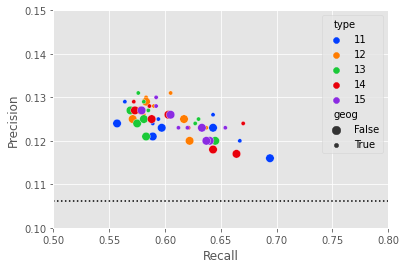

MesesLactanciaMaternaTotal        0.126077
Ind_ninguna_discapac              0.111209
MesesLactanciaMaternaExclusiva    0.083384
Edad_padres_mayor                 0.080368
gasto_ppers_imp                   0.080021
Edad_padres_menor                 0.077190
ingresos_promP_imp                0.070478
n_privaciones                     0.060140
Ind_estudia                       0.054445
gasto_alim_ppers_imp              0.053823
Ind_nivel_sisben_4                0.045661
porc_gasto_alim                   0.045597
Nivel_educ_madre                  0.034026
n_personas_hogar                  0.031140
cod_dpto_17                       0.030011
cod_dpto_23                       0.020360
n_afec_evento_natural             0.019583
cod_dpto_52                       0.014192
cod_dpto_66                       0.013390
cod_dpto_11                       0.009927
dtype: float64

In [ ]:
# Gráfica de precision vs recall coloreado según las variables incluidas
fig = sns.scatterplot(data=metrics_few_imp_geog,#pd.concat([metrics_all, metrics_imp, metrics_few_imp]), 
                      x='recall_test', y='precision_test',
                      hue='type', size='geog', palette='bright')
fig.set_xlim([0.5, 0.8])
fig.set_ylim([0.1, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dotted", linewidth=1.5)
plt.show()
# Columnas más importantes
importance_few_imp_geog.mean().sort_values(ascending=False)[:20]

Aunque las diferencias son mínimas, tomar las 12 variables más importantes, maximiza el *f1-score* y la *precision*.

La inclusión del departamento aumenta la precisión del modelo apenas en un 0.3%.

In [ ]:
# Ordena las variables en orden alfabético
cols_relevantes = sorted(cols_imp[:12])
cols_relevantes

['Edad_padres_mayor',
 'Edad_padres_menor',
 'Ind_estudia',
 'Ind_ninguna_discapac',
 'Ind_nivel_sisben_4',
 'MesesLactanciaMaternaExclusiva',
 'MesesLactanciaMaternaTotal',
 'gasto_alim_ppers_imp',
 'gasto_ppers_imp',
 'ingresos_promP_imp',
 'n_privaciones',
 'porc_gasto_alim']

### **Modelos finales, curva *precision-recall* y distribución de *p-scores***

Para los modelos finales construidos a partir de los datos sociodemográficos (12 variables, con o sin información del departamento) se utilizan todos los datos de entrenamiento y se ampliará el conjunto de parámetros para realizar la búsqueda.

El modelo se evalúa en los beneficiarios del conjunto de prueba.

Modelo final (12 variables importantes): 12 columnas. Tiempo: 8928.35 s.
Archivo 'model_sociodemo.pickle' guardado: 8928.90 s.


random_state  accuracy_train  precision_train  recall_train  f1_train  \
12            12           0.551            0.547         0.597     0.571   

    accuracy_test  precision_test  recall_test  f1_test  max_depth  \
12          0.499           0.119        0.582    0.198          2   

    min_samples_leaf  n_trees  
12                 4      250

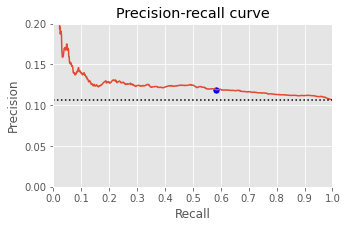

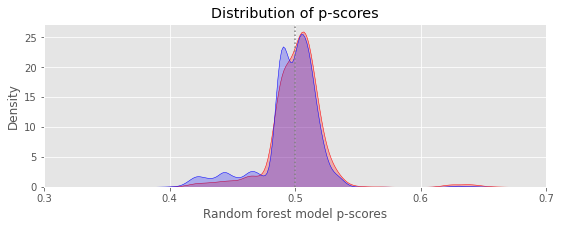

Modelo final (12 variables importantes y departamento): 45 columnas. Tiempo: 9807.90 s.
Archivo 'model_sociodemo_geog.pickle' guardado: 9808.43 s.


random_state  accuracy_train  precision_train  recall_train  f1_train  \
12            12           0.692            0.696         0.681     0.689   

    accuracy_test  precision_test  recall_test  f1_test  max_depth  \
12          0.559           0.123        0.518    0.199         10   

    min_samples_leaf  n_trees  
12                 3      150

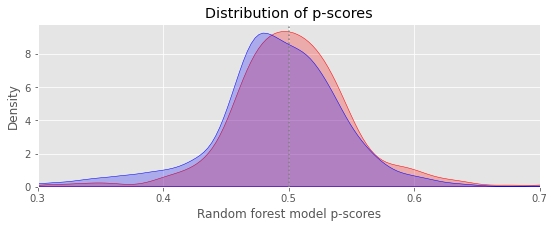

In [ ]:
parameters = {'max_depth': [2 * (i + 1) for i in range(10)],
              'min_samples_leaf': [1, 2, 3, 4],
              'n_estimators': [150, 200, 250]
              }

seed = 12
for geog in [False, True]:
  if geog:
    cols_model = cols_relevantes + cols_dpto
  else:
    cols_model = cols_relevantes
  # Balancea el conjunto de beneficiarios en el conjunto de entrenamiento extrayendo
  # todas las muestras positivas y el mismo número de muestras negativas 
  df_train_unbalanced = df = soc[cols_model + ['IdBeneficiario', 'reincidencia']].dropna()
  df_train_positive = df_train_unbalanced[df_train_unbalanced['reincidencia']]
  df_train_negative = df_train_unbalanced[~df_train_unbalanced['reincidencia']]
  df_train_negative_balanced = df_train_negative.sample(n = len(df_train_positive), random_state=seed)
  df_train = pd.concat([df_train_positive, df_train_negative_balanced]).sample(frac=1, random_state=seed)
  # Extrae las muestras de los beneficiarios de prueba (sin balancear)
  df_test = soc_test[cols_model + ['IdBeneficiario', 'reincidencia']].dropna()
  # Define las variables predictoras y la variable objetivo
  X_train = df_train.drop(columns=['reincidencia', 'IdBeneficiario'])
  X_test = df_test.drop(columns=['reincidencia', 'IdBeneficiario'])
  y_train = df_train['reincidencia']
  y_test = df_test['reincidencia']
  # Realiza una búsqueda exahustiva para optimizar los hiperparámetros del random forest
  classifier = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=seed), 
                            parameters, n_jobs=10, cv=5, verbose=0, scoring=scorers,
                            refit='f1_score')
  # Extrae el mejor modelo y las predicciones en los conjuntos de entrenamiento y validación
  classifier.fit(X=X_train, y=y_train)
  model_ben = classifier.best_estimator_
  y_pred_train = model_ben.predict(X_train)
  y_pred_test = model_ben.predict(X_test)
  # Probabilidades (p-scores) asociadas a cada beneficiario en el conjunto de prueba
  p_scores = [q for p, q in model_ben.predict_proba(X_test)]
  # Guarda las métricas y los hiperparámetros en un dataframe
  metrics = pd.DataFrame({
      'random_state': seed,
      'accuracy_train': accuracy_score(y_train, y_pred_train),
      'precision_train': precision_score(y_train, y_pred_train),
      'recall_train': recall_score(y_train, y_pred_train),
      'f1_train': f1_score(y_train, y_pred_train),
      'accuracy_test': accuracy_score(y_test, y_pred_test),
      'precision_test': precision_score(y_test, y_pred_test),
      'recall_test': recall_score(y_test, y_pred_test),
      'f1_test': f1_score(y_test, y_pred_test),
      'max_depth': classifier.best_params_['max_depth'],
      'min_samples_leaf': classifier.best_params_['min_samples_leaf'],
      'n_trees': classifier.best_params_['n_estimators']
      }, index=[seed]).round(3)
  print(f"Modelo final ({len(cols_relevantes)} variables importantes{' y departamento' * geog}): " +
        f"{df.shape[1] - 2} columnas. Tiempo: {time.time() - t0:.2f} s.")
  name = 'model_sociodemo' + '_geog' * geog
  joblib.dump(model_ben, f'models/{name}.pickle')
  print(f"Archivo '{name}.pickle' guardado: {time.time() - t0:.2f} s.")
  display(metrics)
  # Grafica la curva precision-recall
  plt.rcParams["figure.figsize"] = (5, 3)
  precision, recall, thresholds = precision_recall_curve(y_test, p_scores)
  fig = sns.lineplot(x=recall, y=precision, palette='Reds')
  sns.scatterplot(data=metrics, x='recall_test', y='precision_test', s=50, color='blue')
  fig.set_title("Precision-recall curve")
  fig.set_xticks([0.1 * i for i in range(11)])
  fig.set_yticks([0.05 * i for i in range(21)])
  fig.set_xlim([0, 1])
  fig.set_ylim([0, 0.2])
  fig.set_xlabel('Recall')
  fig.set_ylabel('Precision')
  fig.axhline(y_test.mean(), 0, 1, color='black', linestyle="dotted", linewidth=1.5)
  plt.show()
  # Densidad de cada distribución
  distribution = pd.DataFrame({'p_scores': p_scores,
                               'y_test': y_test})
  plt.rcParams["figure.figsize"] = (9, 3)
  fig = sns.kdeplot(distribution[distribution['y_test']]['p_scores'], 
                    shade=True, color="red", clip=[0, 1], bw_adjust=1)
  fig = sns.kdeplot(distribution[~distribution['y_test']]['p_scores'], 
                    shade=True, color="blue", clip=[0, 1], bw_adjust=1)
  fig.set_xticks([0.1 * i for i in range(11)])
  fig.axvline(0.5, 0, 10, color='grey', linestyle="dotted", linewidth=1.5)
  fig.set_xlim([0.3, 0.7])
  fig.set_title("Distribution of p-scores")
  fig.set_xlabel('Random forest model p-scores')
  fig.set_ylabel('Density')
  plt.show()

In [ ]:
# Guarda la lista de variables más relevantes para su implementación
joblib.dump(cols_relevantes, 'models/model_sociodemo_cols.pickle')
print(f"Lista de las {len(cols_relevantes)} variables más importantes guardadas. " +
        f"Tiempo: {time.time() - t0:.2f} s.")


Lista de las 12 variables más importantes guardadas. Tiempo: 9836.91 s.
